1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

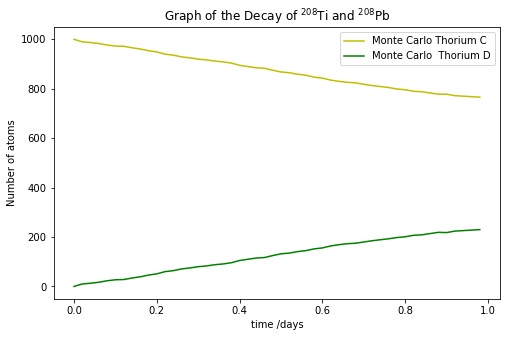

In [88]:
import numpy as np
import matplotlib.pyplot as pyplot
import random


t_half_Ti   = 3.052 
t_half_Pb   = 3.052
N           = 1000
t1           = 1
n_timepoints = 50

    
def simulate_monte_carlo(N, t1, n_timepoints):
     
    dt             = t1 / n_timepoints  
    count_Ti   = np.zeros((n_timepoints)) 
    count_Pb = np.zeros((n_timepoints))
    atoms          = np.ones((N))  
    p_decay_Ti    = 1 - np.power(2, -dt / t_half_Ti)  
    p_decay_Pb    = 1 - np.power(2, -dt / t_half_Pb * np.log(2) /t_half_Pb)
    for idx_time in range(n_timepoints):
        
        count_Ti[idx_time] = (atoms == 1).sum()  
        count_Pb[idx_time] = (atoms == 2).sum()
        
        for idx_atom in range(N):
            
            if atoms[idx_atom] == 1: 
                if random.random() <= p_decay_Ti:
                    atoms[idx_atom] = 2
                else:
                    atoms[idx_atom] = 1
            elif atoms[idx_atom] == 2:
                if random.random() <= p_decay_Pb:
                    atoms[idx_atom] = 3
                else:
                    atoms[idx_atom] = 2
                
    return count_Ti, count_Pb

timebase = np.arange(0, t1, t1/n_timepoints) 
n_Ti, n_Pb = simulate_monte_carlo(N, t1, n_timepoints)   
 
#PLOT THE CODE
pyplot.figure(figsize=(8,5)) 
pyplot.plot(timebase, n_Ti, label = 'Monte Carlo Thorium C', color = 'y')
pyplot.plot(timebase, n_Pb, label = 'Monte Carlo  Thorium D', color = 'g')
pyplot.title('Graph of the Decay of $^{208}$Ti and $^{208}$Pb')
pyplot.ylabel('Number of atoms')
pyplot.xlabel('time /days')
pyplot.legend(loc='upper right') 
pyplot.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [97]:
Z=79
alpha=10**6
e=1.60217 * (10**-19)
E=7.7 * (10**6) * e
epsilon_0=8.85419 * (10**-12)
a0=5.29177 * (10**-11)

n=np.random.rand(alpha)
b=np.sqrt( (-2)*( a0/100 )**(2) * np.log( 1-n ) )
angle=2*np.arctan( Z*e**2 / (2*np.pi*epsilon_0*E*b ) )

res = 0
for a in angle:
    if a > np.pi/2:
        res += 1
    else:
        res +=0

print(' particle whose scattering angle is greater than  𝜋/2  : ', res/alpha)

 particle whose scattering angle is greater than  𝜋/2  :  0.001598


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

Text(0.5, 1.0, '"Plot of the function"')

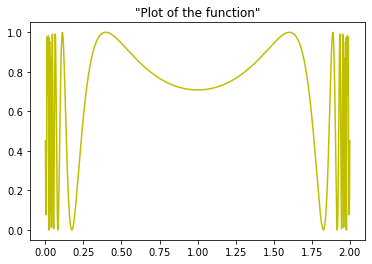

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'y-')
plt.title('"Plot of the function"')


In [41]:
from scipy import random
import numpy as np
 
# limits of integration
a = 0
b = 2
N = 1000

ar = np.zeros(N)

for i in range(len(ar)):
    ar[i] = random.uniform(a, b)
integral = 0.0
 

def f(x):
    return (np.sin(1/(x*(2-x))))**2

for i in ar:
    integral += f(i)

ans = (b-a)/float(N)*integral
 
print("The value calculated by monte carlo integration is {}.".format(ans))

The value calculated by monte carlo integration is 1.4580210277511756.


In [44]:
N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print("The value calculated by monte carlo integration is:",I)

The value calculated by monte carlo integration is: 1.45768


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [99]:
# function in 2 dimention
def func(x,y):
    if (x**2)+(y**2)<=1 :
        return 1
    else :
         return 0

func(2,2)

# Generalize the function for a 10D sphere

def n_Sphere(dimention,vals):
    val=0
    for i in range(dimention):
        val+=np.power(vals[i],2)
    if val<=1:
        return 1
    else:
        return 0

print('result of 10D sphere:',n_Sphere(10, [1,2,3,4,5,6,7,8,9,10]),'\n')
print('result of 5D sphere:',n_Sphere(5, [5,2,6,1,10]))


result of 10D sphere: 0 

result of 5D sphere: 0


In [106]:
N = 10000
points_x = 2*np.random.random(size=(N, 1))-1
points_y = 2*np.random.random(size=(N, 1))-1
c = 0
for i in range(N):
    c+=func(points_x[i],points_y[i])
print("2D =",(4*c/N))

points = 2*np.random.random(size=(N, 10))-1
c = 0
for p in points:
    c+=n_Sphere(10,p)
print("10D = ",(2**10*c/N))

2D = 3.166
10D =  2.6624


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [27]:
from scipy import random
import numpy as np
import math
import matplotlib.pyplot as plt
 
# limits of integration
a = 0
b = 1
N = 1000
 
# create random data
ar = np.zeros(N)
 
#filling with a random value between the limits a and b
for i in range(len(ar)):
    ar[i] = random.uniform(a, b)

integral = 0.0
 
# function of  integration 
def f(x):
    return (x**(-1/2))/(math.exp(x)+1)

plot_val = []
for i in range(1000):
    integral=0
    for i in range(len(ar)):
        ar[i] = random.uniform(a, b)
    for i in ar:
        integral += f(i)

     
    ans = (b-a)/float(N)*integral
    plot_val.append(ans)

print("The value calculated by monte carlo integration is {}.".format(ans))

The value calculated by monte carlo integration is 0.836979952237623.


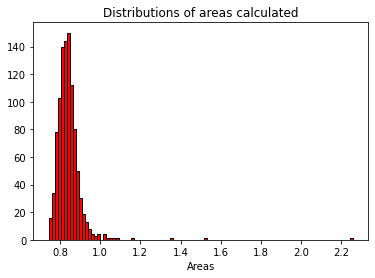

In [79]:
plt.hist (plot_val, bins=100, ec="black",color='r' )
plt.title("Distributions of areas calculated")
plt.xlabel("Areas")
plt.show() 